# Fake Job Posting Classification using Linear Regression and K-NN

# Introduction

In [3]:
import pandas as pd
import numpy as np

<h3>Data Wrangling</h3>

In [9]:
data = pd.read_csv("data_input/fake_job_postings.csv")

In [11]:
data.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [201]:
data.shape

(17880, 18)

In [202]:
#drop unused column
data.drop(['title','location','department','salary_range','employment_type','required_experience','required_education',\
                 'industry','function'], axis=1, inplace=True)

In [203]:
data.isna().sum()

In [204]:
#fill NA with blank space
column = ["company_profile", "description", "requirements", "benefits"]
for i in column:
    data[i] = data[i].fillna("")

<h4>TF-IDF Weighting</h4>

In [ ]:
#running in colab
from sklearn.feature_extraction.text import TfidfVectorizer
column_new = ["company_profile", "description", "requirements", "benefits"]
for c in column_new:
    v = TfidfVectorizer(stop_words = 'english')
    x = v.fit_transform(data[c])
    data[c] = list(x.toarray())

In [ ]:
#running in colab
#sum values from tf-idf result
data_new['company_profile'] = [sum(x) for x in data_new['company_profile']]
data_new['description'] = [sum(x) for x in data_new['description']]
data_new['requirements'] = [sum(x) for x in data_new['requirements']]
data_new['benefits'] = [sum(x) for x in data_new['benefits']]

<h3>Data Exploration</h3>

In [98]:
#output from colab
data_new = pd.read_csv("data_input/tfidf_fakejobs_sum.csv")

In [99]:
data_new.head(2)

,job_id,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,fraudulent
0,1,7.704983,7.549031,7.834614,0.000000,0,1,0,0
1,2,5.923820,9.579981,9.003197,7.704044,0,1,0,0


In [100]:
#check class proportion
print(data_new.fraudulent.value_counts())

0    17014
1      866
Name: fraudulent, dtype: int64


In [101]:
print('Real Post', round(data_new['fraudulent'].value_counts()[0]/len(data_new) * 100), '%')
print('Fake Post', round(data_new['fraudulent'].value_counts()[1]/len(data_new) * 100), '%')

Real Post 95.0 %
Fake Post 5.0 %


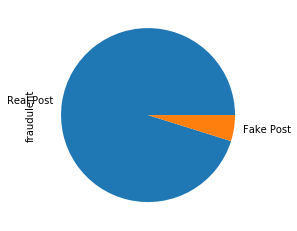

In [102]:
import matplotlib.pyplot as plt

data["fraudulent"].value_counts().plot(kind='pie', labels=['Real Post', 'Fake Post'])

# Classification Process

<h3>Linear Regression Classification</h3>

In [103]:
#split the data
from sklearn.model_selection import train_test_split

#separate predictor and target
X = data_new.drop('fraudulent', axis=1)
y = data_new.fraudulent

#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
#concat X_train and y_train
X = pd.concat([X_train,y_train],axis=1)

In [105]:
X.head(2)

,job_id,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,fraudulent
2112,2113,4.547888,8.899466,5.118812,5.315582,0,1,1,0
7571,7572,5.900860,3.498572,9.766022,7.782071,0,1,0,0


In [106]:
#Linear Regression before upsampling
#Modeling the data as is
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
lr_pred = lr.predict(X_test)

In [107]:
#checking accuracy
accuracy_score(y_test, lr_pred)

0.9493847874720358

<h4>Upsampling Process</h4>

In [108]:
#doing upsampling
from sklearn.utils import resample

real = X[X.fraudulent == 0]
fake = X[X.fraudulent == 1]

fake_upsampling = resample(fake, replace=True, n_samples = len(real), random_state = 42)

In [109]:
#combine result with real data
upsampling_data = pd.concat([real,fake_upsampling])

upsampling_data['fraudulent'].value_counts()

1    13619
0    13619
Name: fraudulent, dtype: int64

<h4>Downsampling Process</h4>

In [110]:
real_downsampling = resample(real, replace=True, n_samples = len(fake), random_state = 42)

In [111]:
#combine result with real data
downsampling_data = pd.concat([fake,real_downsampling])

downsampling_data['fraudulent'].value_counts()

1    685
0    685
Name: fraudulent, dtype: int64

<h4>Linear regression after balancing class</h4>

<h4>Linear Regression from Upsampling Process</h4>

In [112]:
#doing Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

X_train_up = upsampling_data.drop('fraudulent', axis=1)
y_train_up = upsampling_data.fraudulent

upsampled = LogisticRegression(solver='liblinear').fit(X_train_up, y_train_up)


In [113]:
lin_pred_up = upsampled.predict(X_test)

In [114]:
accuracy_score(y_test, lin_pred_up)

0.781599552572707

In [115]:
recall_score(y_test, lin_pred_up)

0.712707182320442

<h4>Linear Regression from Downsampling Process</h4>

In [116]:
X_train_down = downsampling_data.drop('fraudulent', axis=1)
y_train_down = downsampling_data.fraudulent

downsampled = LogisticRegression(solver='liblinear').fit(X_train_down, y_train_down)

In [117]:
lin_pred_down = downsampled.predict(X_test)

In [118]:
accuracy_score(y_test, lin_pred_down)

0.7827181208053692

In [119]:
recall_score(y_test, lin_pred_down)

0.7071823204419889

<h3>K-NN Classification</h3>

In [124]:
from sklearn.neighbors import KNeighborsClassifier  
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i).fit(X_train_down, y_train_down)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Average')

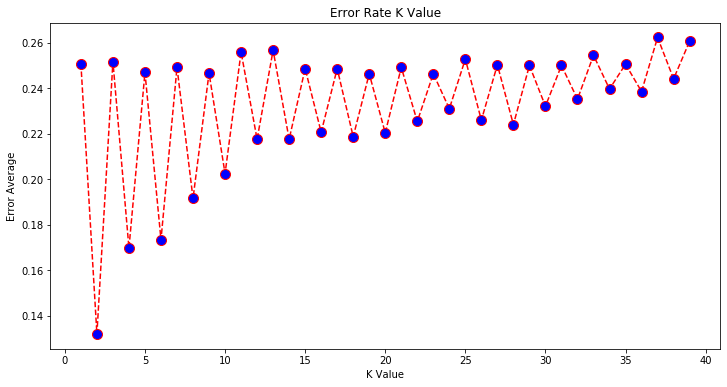

In [125]:
#choosing the best K
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Error Average')

In [126]:
classifier = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

In [127]:
knn_pred = classifier.predict(X_test)

In [128]:
#accuracy score
accuracy_score(y_test, knn_pred)

0.9695190156599552

In [129]:
#recall score
recall_score(y_test, knn_pred)

0.580110497237569